# **Time Series Prediction with LSTM Using PyTorch**

This kernel is based on *datasets* from

[Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

## Reference
- https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb

## **Import Packages**

In [1]:
# For data preprocess
import os
import csv
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable

## **Set Random Seed**

In [2]:
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

## **Get GPU Resource**

In [3]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(device)

cuda


## **Setup Hyper-parameters**

In [4]:
# dataset
infected_data_path = os.path.join('..', 'data', 'timeline_diagnosed.csv')
population_data_path = os.path.join('..', 'data', 'population.csv')
latitude_data_path = os.path.join('..', 'data', 'latitude.csv')
age_data_path = os.path.join('..', 'data', 'age.csv')

# data selection
seq_length = 7  # X(seq_length) + Y(1)

start_date = "2022-03-10"
end_date   = "2022-06-01"
delta_date = datetime.strptime(end_date, "%Y-%m-%d") - datetime.strptime(start_date, "%Y-%m-%d")
data_size = delta_date.days + 1 - seq_length
print(data_size)
test_size = 3
train_size = data_size - test_size
test_start_date = (pd.to_datetime(end_date) + pd.DateOffset(days=(-test_size+1))).strftime("%Y-%m-%d")
start_date_y = (pd.to_datetime(start_date) + pd.DateOffset(days=(seq_length))).strftime("%Y-%m-%d")

pred_long_size = 14

train_city_codes = ["KEE", "NWT", "TPE", "TXG", "NAN", "TNN", "HUA"]
test_city_codes = ["KEE", "NWT", "TPE", "TAO", "HSZ", "HSQ", "MIA", "TXG", "CHA", "NAN", "YUN", "CYQ", "CYI", "TNN", "KHH", "PIF", "ILA", "HUA", "TTT", "PEN", "KIN", "LIE"]
# city_codes = ["NWT", "TPE", "TXG", "KHH", "TTT", "PEN"]

# model parameters
num_epochs = 18000
# num_batchs = len(train_city_codes)
early_stop = 6000
learning_rate = 0.003

input_size = 1
hidden_size = 1
num_layers = 1
num_classes = 1

criterion = torch.nn.MSELoss()    # mean-squared error for regression
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# save model
model_dir = os.path.join('..', 'models', 'LSTM-static')
os.makedirs(model_dir, exist_ok=True)
save_path = os.path.join('..', 'models', 'LSTM-static', 'model.pth')

# others
seed = 20220605

77


## **Check Raw Data**

In [5]:
infected_dataset = pd.read_csv(infected_data_path)
population_dataset = pd.read_csv(population_data_path)
latitude_dataset = pd.read_csv(latitude_data_path)
age_dataset = pd.read_csv(age_data_path)
print(infected_dataset)
print(population_dataset)
print(latitude_dataset)
print(age_dataset)

      city        date  count  accumulateCount
0      KEE  2020-01-28      0                0
1      NWT  2020-01-28      0                0
2      TPE  2020-01-28      0                0
3      TAO  2020-01-28      0                0
4      HSZ  2020-01-28      0                0
...    ...         ...    ...              ...
19821  TTT  2022-06-07    933            19838
19822  PEN  2022-06-07    314             4353
19823  KIN  2022-06-07     99             3191
19824  LIE  2022-06-07     57              843
19825   TW  2022-06-07  80184          2606905

[19826 rows x 4 columns]
   Region        area  numCity  numVillage  numNeighborhood  numHouse  \
0      TW  36197.0669      368        7746           142480   9002584   
1     NWT   2052.5667       29        1032            22150   1620113   
2     TPE    271.7997       12         456             9572   1043569   
3     TAO   1220.9540       13         516            11930    863712   
4     TXG   2214.8968       29         625   

## **Preprocessing**

In [6]:
class Datapack():
    def __init__(self):
        self.timeline_x = None
        self.timeline_y = None
        self.static_x = None

class CityDataset():
    def __init__(self, city):
        self.city = city
        self.train = None
        self.val = None
        self.test = None
        self.get_population(population_dataset)
        self.get_density(population_dataset)
        self.get_lat_lon(latitude_dataset)
        self.get_age(age_dataset)

    def sliding_windows(self, data, start_idx, data_size):
        x = []
        y = []

        for i in range(start_idx, data_size):
            _x = data[i:(i+seq_length)]
            _y = data[i+seq_length]
            x.append(_x)
            y.append(_y)

        return np.array(x),np.array(y)

    def normalization(self, city_dataset):
        return city_dataset * 100 / self.population
    
    def denormalization(self, city_dataset):
        return np.rint(city_dataset * self.population / 100).astype(int)

    def get_population(self, dataset):
        self.population = int(dataset[ dataset['Region'] == self.city ]['population'])
        return
    
    def get_density(self, dataset):
        self.density = float(dataset[ dataset['Region'] == self.city ]['densityArea'])
        return

    def get_lat_lon(self, dataset):
        self.latitude = float(dataset[ dataset['city'] == self.city ]['latitude'])
        self.longitude = float(dataset[ dataset['city'] == self.city ]['longitude'])
        return

    def get_age(self, dataset):
        # 0 ~ 14, 15 ~ 44, 45 ~ 69, 70 ~ N
        self.age_1 = float(dataset[ dataset['city'] == self.city ][['0', '5', '10']].sum(axis=1)) / self.population
        self.age_2 = float(dataset[ dataset['city'] == self.city ][['15', '20', '25', '30', '35', '40']].sum(axis=1)) / self.population
        self.age_3 = float(dataset[ dataset['city'] == self.city ][['45', '50', '55', '60', '65']].sum(axis=1)) / self.population
        self.age_4 = float(dataset[ dataset['city'] == self.city ][['70', '75', '80', '85', '90', '95', '100']].sum(axis=1)) / self.population

    def get_timeline(self, start_idx, data_size):
        mask = ((infected_dataset["city"] == self.city)
                & (infected_dataset["date"] >= start_date))
        city_dataset = infected_dataset[mask]["count"].values.reshape(-1, 1)

        # TODO: city_dataset / population * 100
        city_dataset = self.normalization(city_dataset)

        # TODO: sliding window
        x, y = self.sliding_windows(city_dataset, start_idx, data_size)
        return x, y

    def get_static(self):
        population = self.population / 4000000
        density = self.density / 5000
        latitude = (self.latitude - 22.5) / 3.7
        longitude = (self.longitude - 118.3) /3.5
        age_1 = (self.age_1 - 0.085) / 0.081
        age_2 = (self.age_2 - 0.367) / 0.064
        age_3 = (self.age_3 - 0.329) / 0.076
        age_4 = (self.age_4 - 0.076) / 0.071

        return [population, density, latitude, longitude, age_1, age_2, age_3, age_4]

    def get_train(self):
        self.train = Datapack()
        self.val = Datapack()

        x, y = self.get_timeline(0, train_size)

        # TODO: timeline data preprocessing
        train_indices = [i for i in range(train_size) if i%10 != 7]
        val_indices = [i for i in range(train_size) if i%10 == 7]

        train_train_size = len(train_indices)
        train_val_size = len(val_indices)


        self.train.timeline_x = Variable(torch.Tensor(np.array(x[train_indices])))
        self.train.timeline_y = Variable(torch.Tensor(np.array(y[train_indices])))

        self.val.timeline_x = Variable(torch.Tensor(np.array(x[val_indices])))
        self.val.timeline_y = Variable(torch.Tensor(np.array(y[val_indices])))

        static_x = self.get_static()
        static_x = np.array(static_x)
        static_size = len(static_x)
        self.train.static_x = Variable(torch.Tensor(np.resize(static_x, (train_train_size, static_size))))
        self.val.static_x   = Variable(torch.Tensor(np.resize(static_x, (train_val_size, static_size))))

        return self.train, self.val

    def get_test(self):
        self.test = Datapack()
        x, y = self.get_timeline(train_size, train_size + test_size)

        # TODO: timeline data preprocessing
        self.test.timeline_x = Variable(torch.Tensor(np.array(x)))
        self.test.timeline_y = Variable(torch.Tensor(np.array(y)))

        static_x = self.get_static()
        static_x = np.array(static_x)
        static_size = len(static_x)

        self.test.static_x = Variable(torch.Tensor(np.resize(static_x, (test_size, static_size))))

        return self.test

    def get_all(self):
        self.all = Datapack()
        x, y = self.get_timeline(0, train_size + test_size)

        # TODO: timeline data preprocessing
        self.all.timeline_x = Variable(torch.Tensor(np.array(x)))
        self.all.timeline_y = Variable(torch.Tensor(np.array(y)))

        static_x = self.get_static()
        static_x = np.array(static_x)
        static_size = len(static_x)

        self.all.static_x = Variable(torch.Tensor(np.resize(static_x, (train_size + test_size, static_size))))
        
        return self.all

    def get_result(self, timeline):
        # TODO: revert to original scale
        return self.denormalization(timeline.data.numpy())

## **Model**
LSTM + fully connected layer

In [7]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc_lstm = nn.Linear(hidden_size * num_layers, num_classes)
        self.net_static = nn.Sequential(
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
        )
        self.net_combine = nn.Sequential(
            nn.Linear(1+num_classes, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
        )

    def forward(self, timeline, static_data):
        h_0 = Variable(torch.zeros(
            self.num_layers, 
            timeline.size(0), 
            self.hidden_size,
            device=device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers,
            timeline.size(0),
            self.hidden_size,
            device=device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(timeline, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size * self.num_layers)
        
        out_lstm = self.fc_lstm(h_out)
        out_static = self.net_static(static_data)
        combine = torch.cat((out_lstm, out_static), dim=1)
        out = self.net_combine(combine)
        
        return out

# **Train/Test**

## **Training**

In [8]:
def train(model):
    min_loss = np.infty
    min_loss_epoch = -1
    loss_record = {'train': [], 'val': []}
    early_stop_cnt = 0

    city_dict = {}
    for city in train_city_codes:
        city_data = CityDataset(city)
        train_data, val_data = city_data.get_train()
        city_dict[city] = {
            "train": train_data,
            "val": val_data
        }

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        for city in train_city_codes:
            timeline_x = city_dict[city]["train"].timeline_x.to(device)
            static_x = city_dict[city]["train"].static_x.to(device)
            timeline_y = city_dict[city]["train"].timeline_y.to(device)

            pred = model(timeline_x, static_x)
        
            # obtain the loss function
            loss = criterion(pred, timeline_y)
            loss.backward()
            optimizer.step()
            loss_record['train'].append(loss.detach().cpu().item())

        val_loss = val(model, city_dict)
        if val_loss < min_loss:
            min_loss = val_loss
            min_loss_epoch = epoch
            # print('Saving {} model (epoch = {:4d}, val loss = {:.4f})'
            #     .format(city, epoch + 1, min_loss))
            torch.save(model.state_dict(), save_path)
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        loss_record['val'].append(val_loss)

        if (epoch+1) % 100 == 0:
            print("Epoch: %d, loss: %1.5f, %1.5f" % (epoch+1, loss.item(), val_loss))
        if early_stop_cnt > early_stop:
            break
    
    return min_loss, min_loss_epoch, loss_record

## **Validation**

In [9]:
def val(model, city_dict):
    model.eval()

    total_loss = 0
    for city in train_city_codes:
        timeline_x = city_dict[city]["val"].timeline_x.to(device)
        static_x = city_dict[city]["val"].static_x.to(device)
        timeline_y = city_dict[city]["val"].timeline_y.to(device)

        with torch.no_grad():
            pred = model(timeline_x, static_x)
            loss = criterion(pred, timeline_y)
            total_loss += loss.detach().cpu().item()

    return total_loss

## **Train for Cities**

In [10]:
same_seeds(seed)

lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)
min_loss, min_loss_epoch, loss_record = train(lstm)
print(f"min_loss = {min_loss}, in {min_loss_epoch}")
del lstm

Epoch: 100, loss: 0.00359, 0.01466
Epoch: 200, loss: 0.00207, 0.00965
Epoch: 300, loss: 0.00192, 0.00877
Epoch: 400, loss: 0.00280, 0.01083
Epoch: 500, loss: 0.00238, 0.01514
Epoch: 600, loss: 0.00247, 0.00782
Epoch: 700, loss: 0.00184, 0.00922
Epoch: 800, loss: 0.00160, 0.00816
Epoch: 900, loss: 0.00232, 0.00727
Epoch: 1000, loss: 0.00218, 0.00709
Epoch: 1100, loss: 0.00180, 0.00802
Epoch: 1200, loss: 0.00197, 0.01019
Epoch: 1300, loss: 0.00214, 0.01351
Epoch: 1400, loss: 0.00161, 0.01018
Epoch: 1500, loss: 0.00140, 0.00770
Epoch: 1600, loss: 0.00182, 0.00730
Epoch: 1700, loss: 0.00192, 0.00758
Epoch: 1800, loss: 0.00169, 0.00811
Epoch: 1900, loss: 0.00149, 0.00736
Epoch: 2000, loss: 0.00176, 0.00898
Epoch: 2100, loss: 0.00190, 0.01215
Epoch: 2200, loss: 0.00163, 0.00652
Epoch: 2300, loss: 0.00136, 0.00661
Epoch: 2400, loss: 0.00200, 0.01169
Epoch: 2500, loss: 0.00143, 0.00627
Epoch: 2600, loss: 0.00131, 0.00636
Epoch: 2700, loss: 0.00185, 0.01163
Epoch: 2800, loss: 0.00179, 0.00767
E

## **Training and Validation Loss**

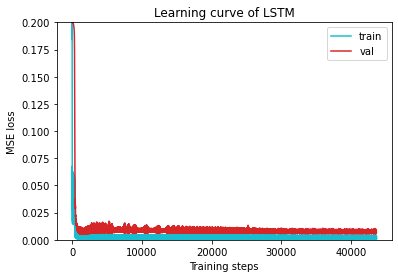

In [11]:
total_steps = len(loss_record['train'])
x_1 = range(total_steps)
x_2 = x_1[::len(loss_record['train']) // len(loss_record['val'])]
figure(figsize=(6, 4))
plt.plot(x_1, loss_record['train'], c='tab:cyan', label='train')
plt.plot(x_2, loss_record['val'], c='tab:red', label='val')
plt.xlabel("Training steps")
plt.ylabel("MSE loss")
plt.ylim(0, 0.2)
plt.title(f"Learning curve of LSTM")
plt.legend()
plt.show()

## **Testing**

Define plotting function.

In [12]:
def plot_predict(city, data_type, pred, real, start_date):
    plt.plot(pred)
    plt.plot(real)
    plt.suptitle(f"Time-Series Prediction for {city} {data_type}")
    plt.xlabel(f"Time (days) from {start_date}")
    plt.ylabel("Number of New Cases")
    plt.legend(("predicted", "real"))

    if data_type == "Data":
        plt.axvline(x=(train_size-1), c='red', linestyle=':')
    plt.show()

Test for each city and plot it.

In [13]:
def test(model, timeline_x, static_x, timeline_y):
    model.eval()
    _timeline_x = timeline_x.to(device)
    _timeline_y = timeline_y.to(device)
    _static_x = static_x.to(device)
    pred = model(_timeline_x, _static_x)
    loss = criterion(pred, _timeline_y)

    return pred.detach().cpu(), loss.item()

In [14]:
def printPredError(pred, real):
    # RMSE
    print(f"RMSE: {np.sqrt(np.mean(np.power(pred - real, 2))):.2f}")
    # MAPE
    print(f"MAPE: {np.mean(np.abs(real - pred) / real) * 100:.2f}%")

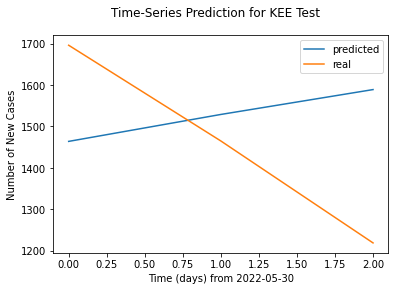

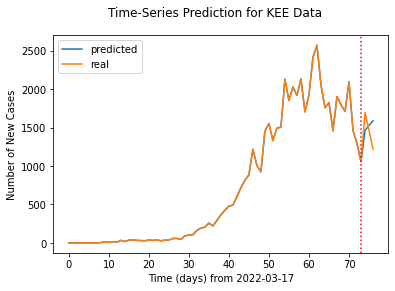

RMSE: 254.83
MAPE: 16.13%


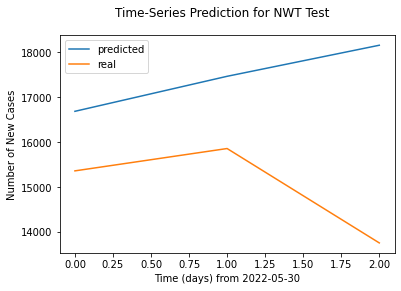

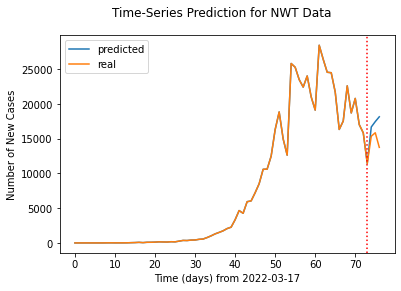

RMSE: 2809.54
MAPE: 16.91%


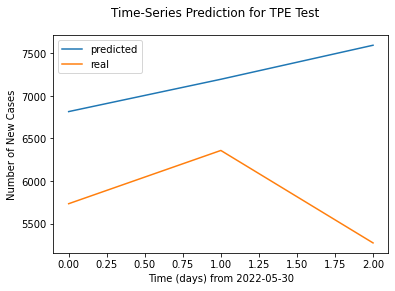

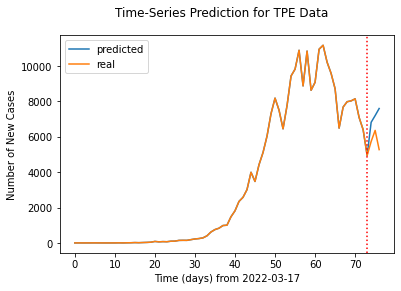

RMSE: 1557.18
MAPE: 25.38%


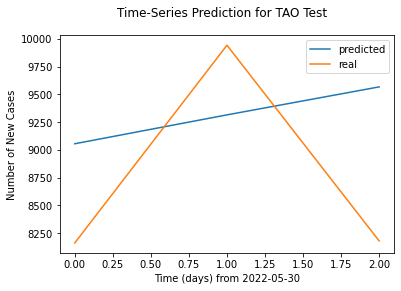

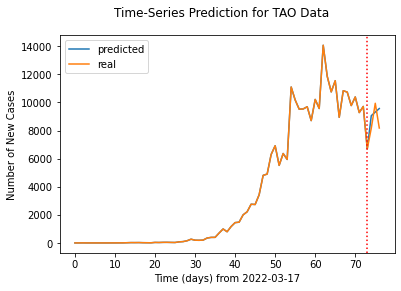

RMSE: 1018.88
MAPE: 11.40%


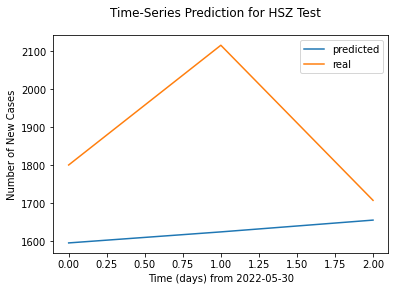

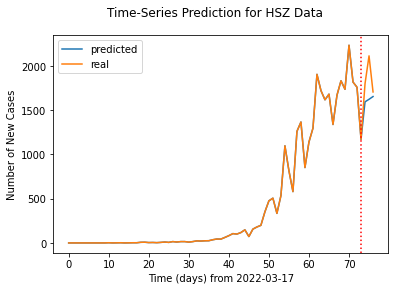

RMSE: 308.66
MAPE: 12.55%


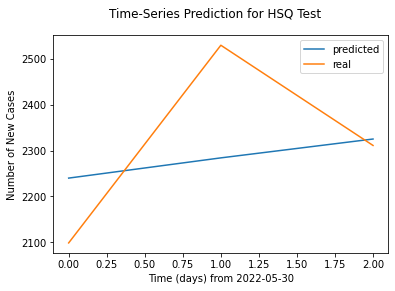

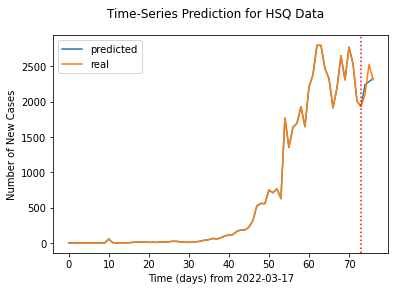

RMSE: 163.40
MAPE: 5.67%


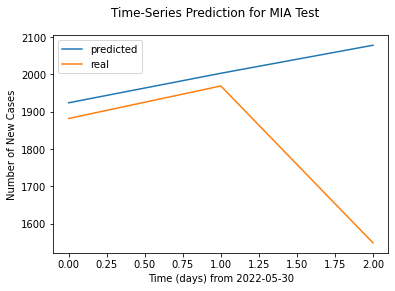

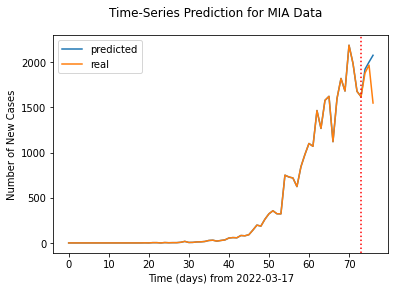

RMSE: 307.01
MAPE: 12.70%


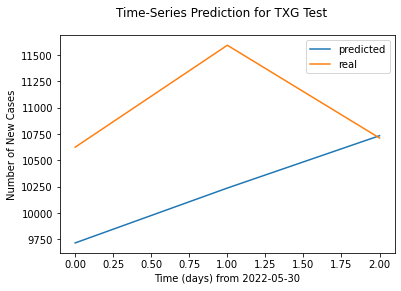

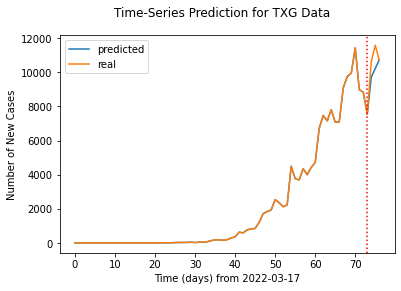

RMSE: 942.60
MAPE: 6.82%


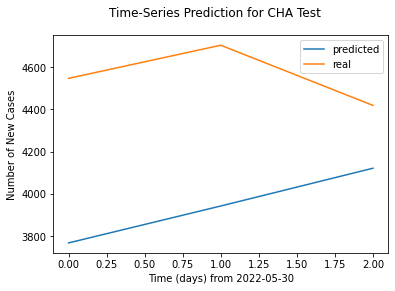

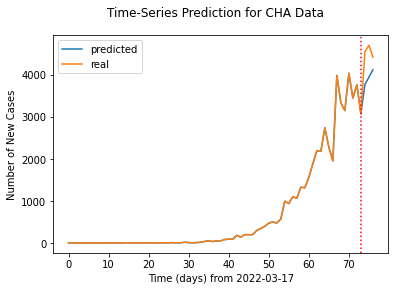

RMSE: 652.65
MAPE: 13.37%


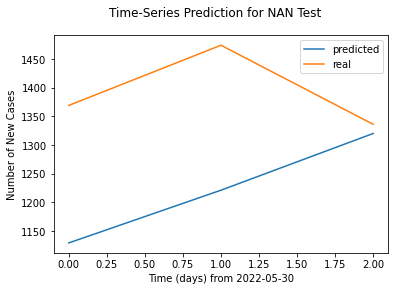

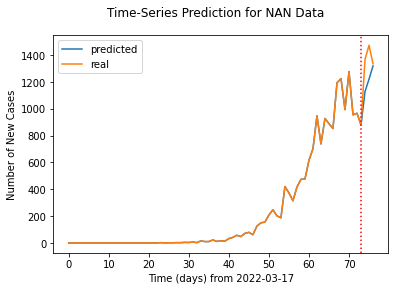

RMSE: 201.55
MAPE: 11.96%


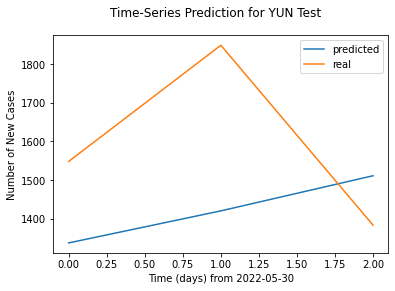

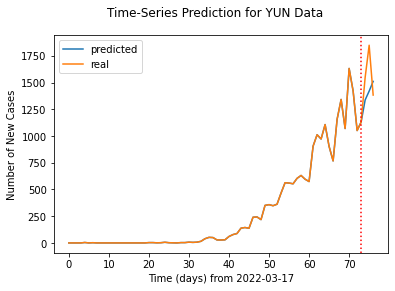

RMSE: 285.74
MAPE: 15.36%


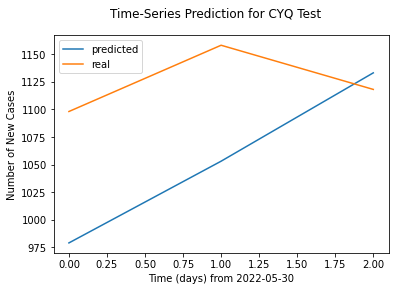

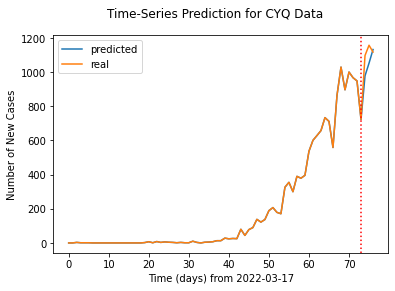

RMSE: 92.03
MAPE: 7.08%


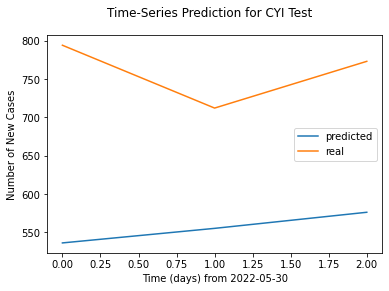

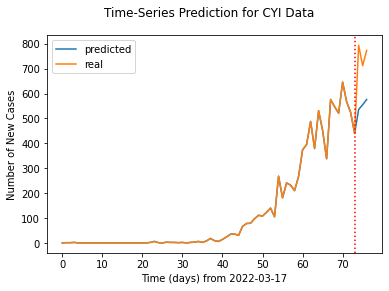

RMSE: 208.18
MAPE: 26.68%


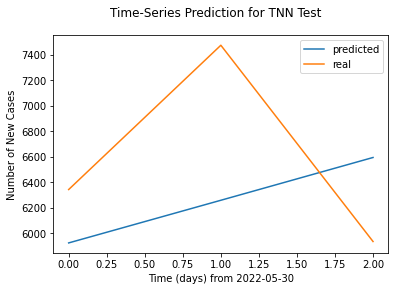

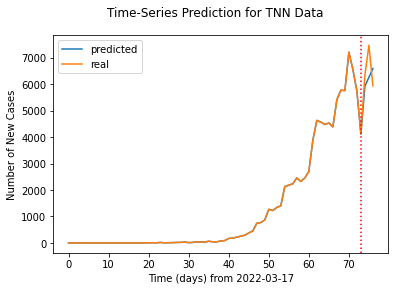

RMSE: 832.96
MAPE: 11.31%


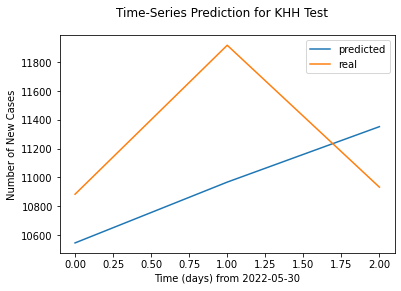

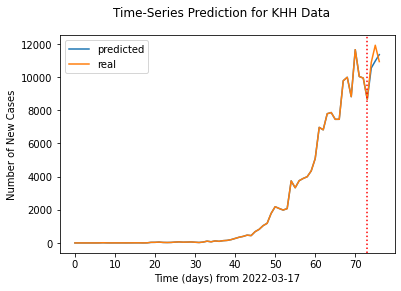

RMSE: 630.65
MAPE: 4.97%


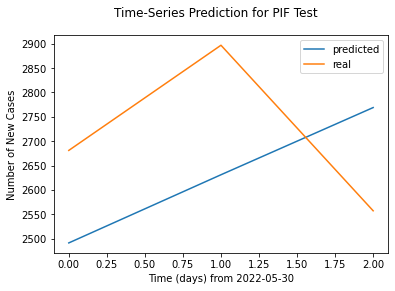

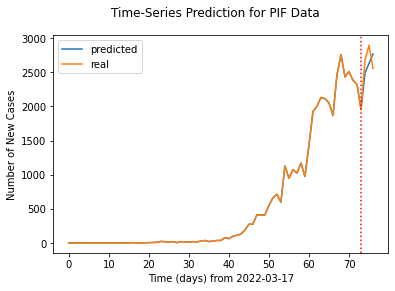

RMSE: 224.94
MAPE: 8.19%


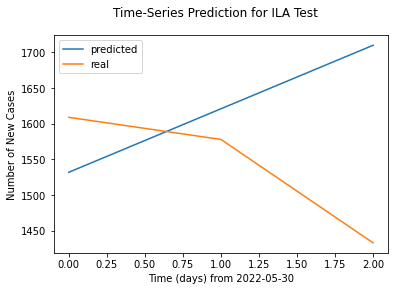

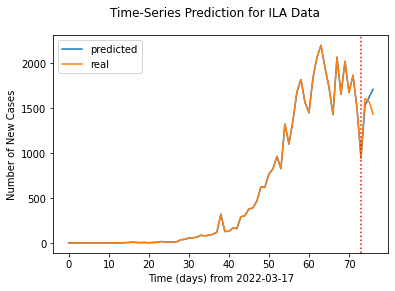

RMSE: 167.84
MAPE: 8.95%


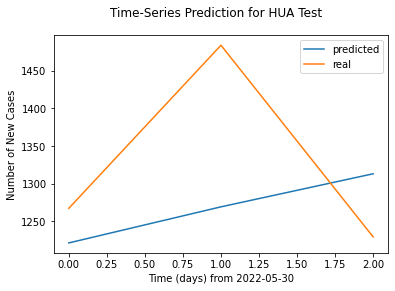

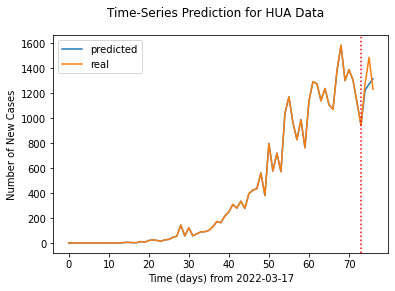

RMSE: 135.89
MAPE: 8.32%


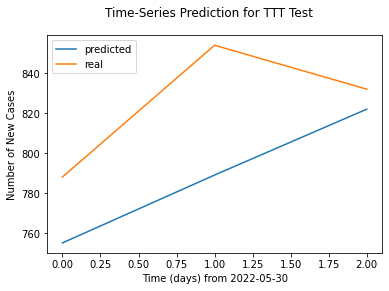

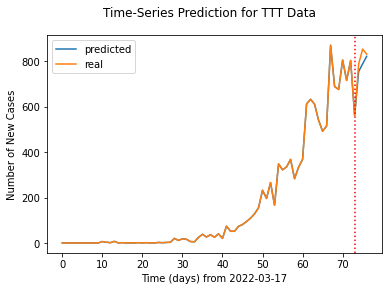

RMSE: 42.48
MAPE: 4.33%


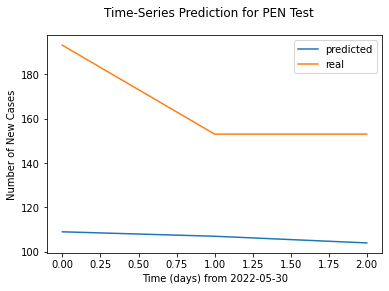

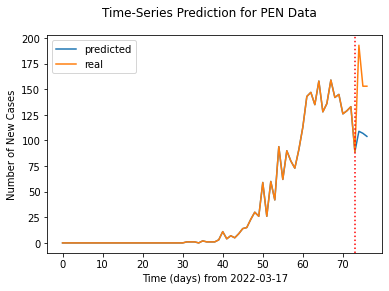

RMSE: 62.11
MAPE: 35.20%


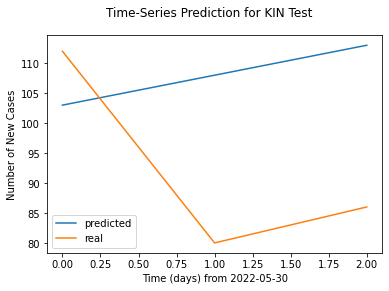

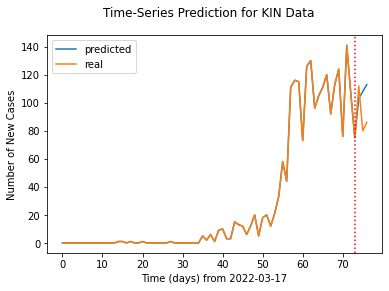

RMSE: 23.05
MAPE: 24.81%


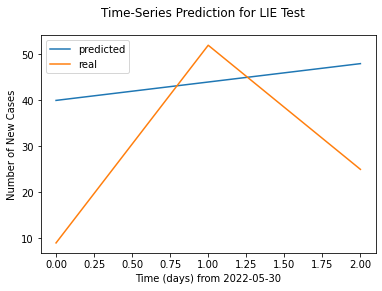

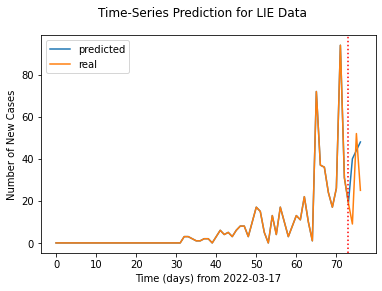

RMSE: 22.76
MAPE: 150.61%


In [15]:
for city in test_city_codes:
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)
    ckpt = torch.load(save_path, map_location='cpu')
    lstm.load_state_dict(ckpt)

    city_data = CityDataset(city)
    city_test_data = city_data.get_test()
    city_all_data = city_data.get_all()

    # test set: real & predicted data -> predicted data
    timeline_x = city_test_data.timeline_x[[0]].clone()
    timeline_y = city_test_data.timeline_y
    static_x = city_test_data.static_x
    total_loss = 0
    total_pred = []

    for i in range(test_size):
        pred, loss = test(lstm, timeline_x, static_x[[i]], timeline_y[[i]])
        total_loss += loss
        total_pred.append(pred)
        timeline_x = torch.cat((timeline_x[:,1:], torch.unsqueeze(pred, 0)), 1)
    total_pred = torch.cat(total_pred)

    _total_pred = city_data.get_result(total_pred)
    timeline_y = city_data.get_result(timeline_y)
    plot_predict(city, "Test", _total_pred, timeline_y, test_start_date)

    # with history
    timeline_y_all = city_all_data.timeline_y
    pred_y = timeline_y_all.clone()
    for i in range(len(total_pred)):
        pred_y[-test_size+i][0] = total_pred[i][0]
    _timeline_y_all = city_data.get_result(timeline_y_all)
    _pred_y = city_data.get_result(pred_y)
    plot_predict(city, "Data", _pred_y, _timeline_y_all, start_date_y)

    printPredError(_total_pred, timeline_y)

    del lstm

## **Prediction for Long Term**

In [16]:
def pred_long(model, timeline_x, static_x):
    model.eval()
    _timeline_x = timeline_x.to(device)
    _static_x = static_x.to(device)
    pred = model(_timeline_x, _static_x)

    return pred.detach().cpu()

In [17]:
def plot_predict_long(city, pred, start_date):
    plt.plot(pred)
    plt.suptitle(f"Time-Series Prediction for {city}")
    plt.xlabel(f"Time (days) from {start_date}")
    plt.ylabel("Number of New Cases")
    plt.legend(("predicted"))
    plt.axvline(x=(train_size-1), c='red', linestyle=':')
    plt.show()

In [18]:
def save_pred(city, pred):
    with open(os.path.join('..', 'output', 'LSTM-static', f'{city}.csv'), "w") as out_file:
        out_file.write("new_cases\n")
        np.savetxt(out_file, pred, fmt='%s', delimiter=',')

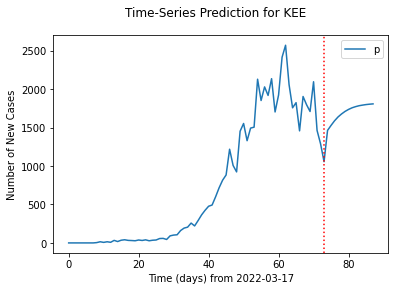

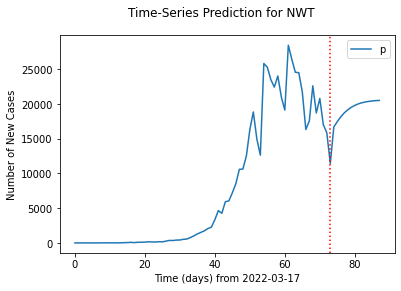

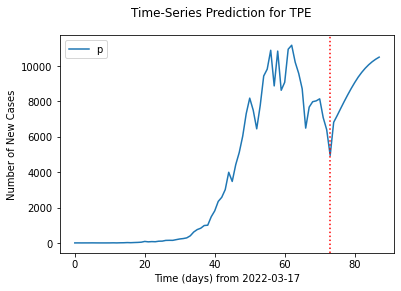

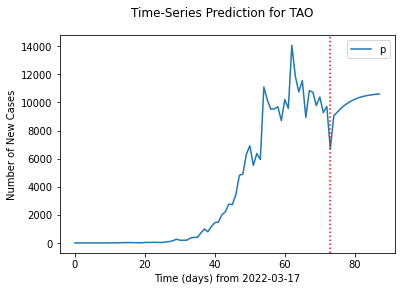

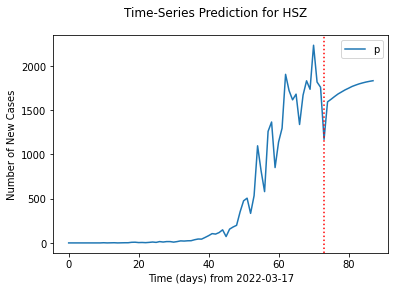

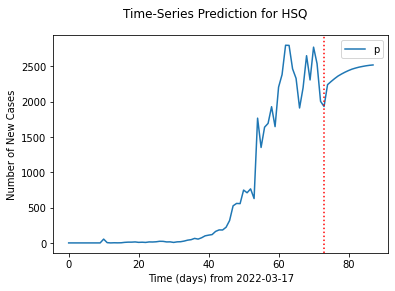

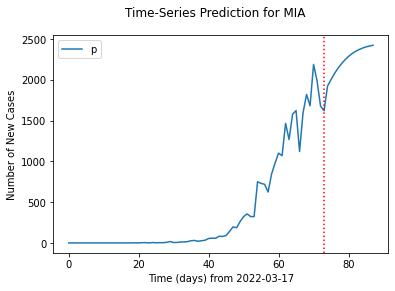

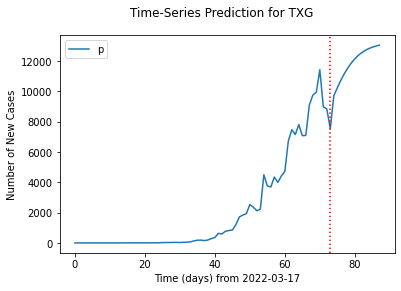

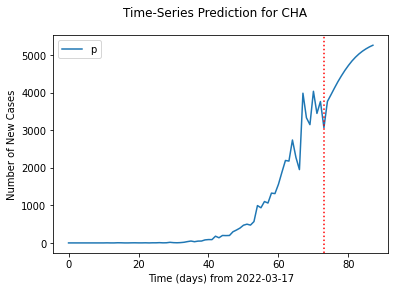

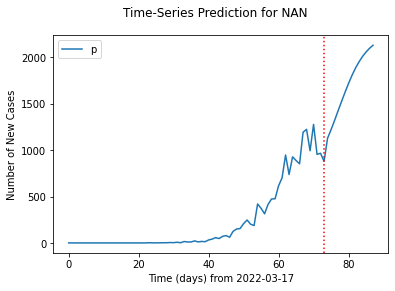

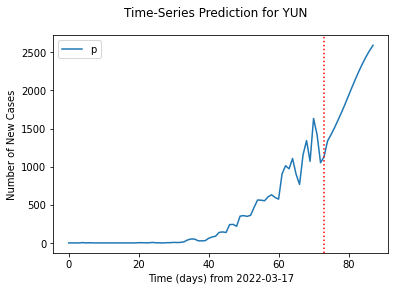

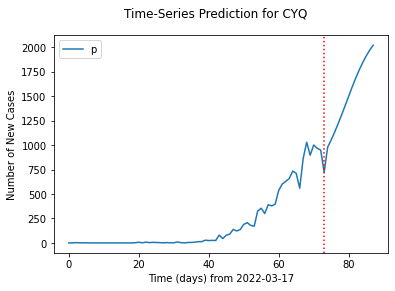

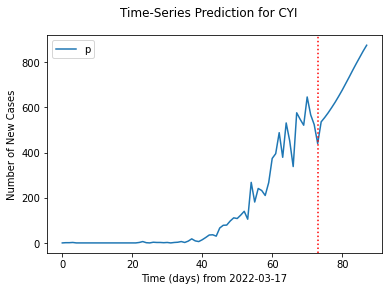

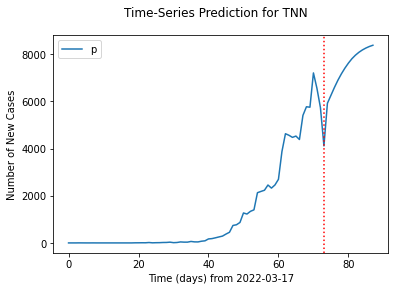

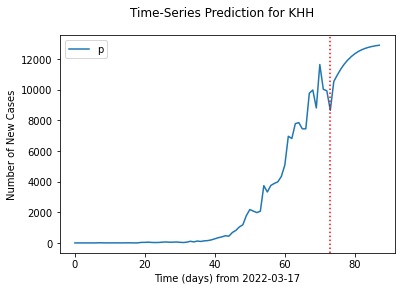

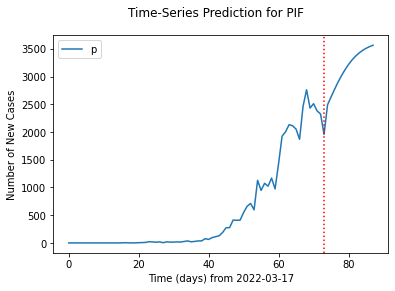

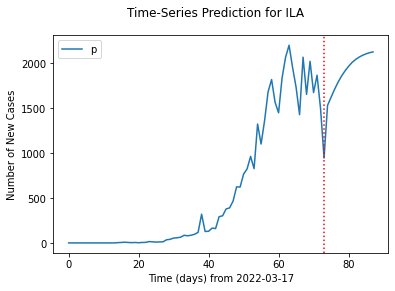

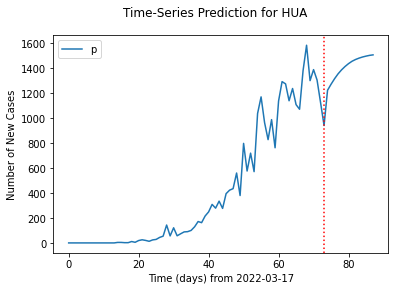

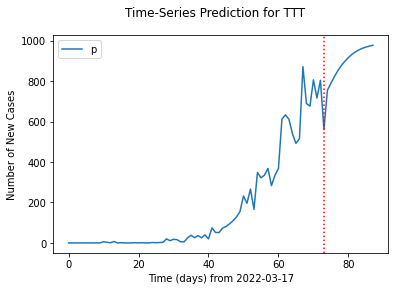

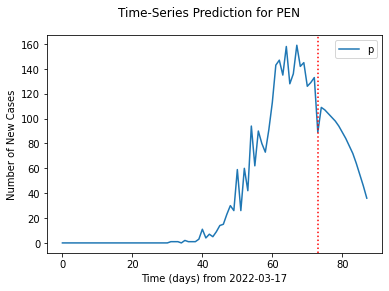

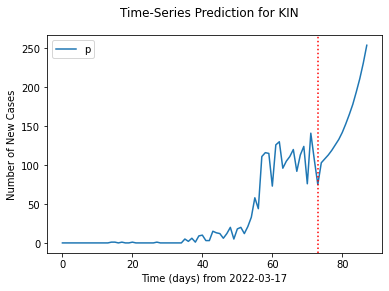

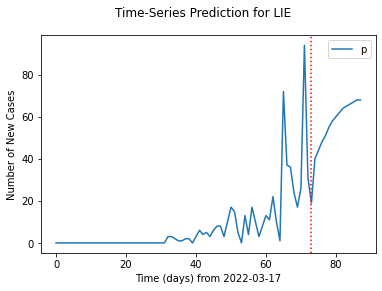

In [19]:
os.makedirs(os.path.join('..', 'output', 'LSTM-static'), exist_ok=True)
for city in test_city_codes:
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)
    ckpt = torch.load(save_path, map_location='cpu')
    lstm.load_state_dict(ckpt)

    city_data = CityDataset(city)
    city_test_data = city_data.get_test()
    city_all_data = city_data.get_all()

    # test set: real & predicted data -> predicted data
    timeline_x = city_test_data.timeline_x[[0]].clone()
    static_x = city_test_data.static_x
    total_pred = []

    for i in range(pred_long_size):
        pred = pred_long(lstm, timeline_x, static_x[[0]])
        total_pred.append(pred)
        timeline_x = torch.cat((timeline_x[:,1:], torch.unsqueeze(pred, 0)), 1)
    total_pred = torch.cat(total_pred)

    # with history
    timeline_y_all = city_all_data.timeline_y
    pred_y = timeline_y_all.clone()

    pred_y = pred_y[:-test_size]
    pred_y = torch.cat((pred_y, torch.zeros(pred_long_size, 1)), 0)
    
    for i in range(pred_long_size):
        pred_y[-pred_long_size+i][0] = total_pred[i][0]
    _pred_y = city_data.get_result(pred_y)
    plot_predict_long(city, _pred_y, start_date_y)

    save_pred(city, _pred_y)

    del lstm